In [3]:
import numpy as np
import pandas as pd
import urllib.request as requests
import string
import re
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('dataset.csv')
data.head(10)

,sentiment,comment
0,5,Chất lượng sản phẩm:tốt Đúng với mô tả:đẹp Hà...
1,5,Với giá thành này thì hàng khá ổn . Bị lỗi pin...
2,5,Tính năng nổi bật:máy sáng Đúng với mô tả:chuẩ...
3,4,"Máy đã thay vỏ nên ngoại hình đẹp, dùng làm má..."
4,5,Chất lượng sản phẩm:sản phẩm dùng ổn định Máy...
5,5,Rất oke nè giá học sinh sinh viên shop rất uy ...
6,5,Chất lượng sản phẩm:ok mọi thứ tạm ổn so với t...
7,1,Mọi người k nên mua nha..shop bán điện thoại q...
8,5,Hàng tốt .. đt mới tinh mớii tinh mọi người nê...
9,5,Máy ok Ship hàng nhanh


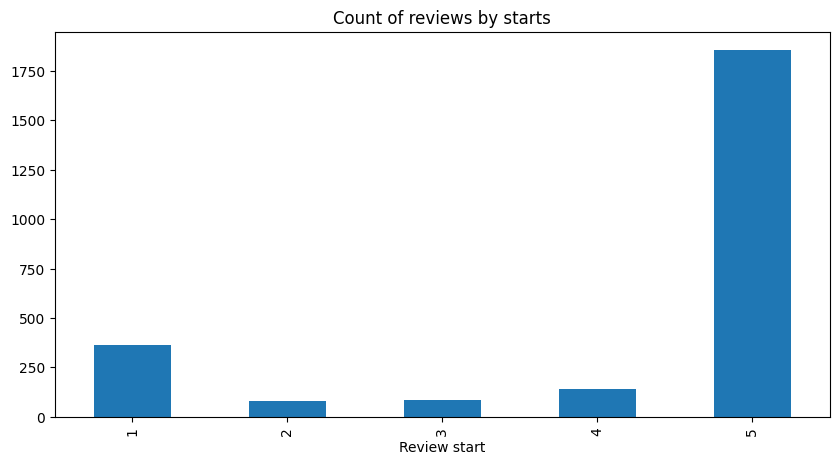

In [5]:
ax = data['sentiment'].value_counts().sort_index().plot(kind='bar', 
                                                        title='Count of reviews by starts',
                                                        figsize=(10,5))
ax.set_xlabel('Review start')
plt.show()

Pre Processing

In [6]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smile_emoji        = r"[8:=;]['`\-]?[)d]+"
sad_emoji          = r"[8:=;]['`\-]?\(+"
neutral_emoji      = r"[8:=;]['`\-]?[\/|l*]"
lol_emoji          = r"[8:=;]['`\-]?p+"

def preprocess(input:str):
    data = requests.urlopen(r"https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt")
    stop_words = [item.decode("utf-8").strip() for item in list(data)]
    # Lower
    input = input.lower()
    # clean
    input = input.strip().replace('\n', '')

    # Replace 3 or more consecutive letters by 2 letter.
    input = re.sub(sequencePattern, seqReplacePattern, input)
    
    # Replace all emojis.
    input = re.sub(r'<3', 'tim', input)
    input = re.sub(smile_emoji, 'cười', input)
    input = re.sub(sad_emoji, 'buồn', input)
    input = re.sub(neutral_emoji, 'bình thường', input)
    input = re.sub(lol_emoji, 'vui', input)
    
    # Keep word
    input = re.sub('\[.*?\]', ' ', input)
    input = re.sub('https?://\S+|www\.\S+', ' ', input)
    input = re.sub('<.*?>+', ' ', input)
    input = re.sub('[%s]' % re.escape(string.punctuation), ' ', input)
    input = re.sub('\n', ' ', input)
    input = re.sub('\w*\d\w*', ' ', input)
    
    return ' '.join([word for word in input.split() if word not in stop_words])

data.dropna()
data["comment"] = data["comment"].apply(lambda x: preprocess(x))
data.head(10)

,sentiment,comment
0,5,chất sản phẩm mô tả đẹp hàng đẹp mua mượt shop...
1,5,giá thành hàng ổn lỗi pin shop gửi pin mk mk u...
2,5,năng nổi bật máy mô tả chuẩn chất sản phẩm hàn...
3,4,máy thay vỏ ngoại hình đẹp máy phụ ổn ngon nút...
4,5,chất sản phẩm sản phẩm ổn định máy đẹp lỗi gói...
5,5,oke nè giá học sinh sinh viên shop uy tín nhu ...
6,5,chất sản phẩm ok tạm ổn tầm giá mô tả
7,1,k mua nha shop điện thoại tệ vs giá tệ nhân ph...
8,5,hàng đt tinh mớii tinh mua
9,5,máy ok ship hàng


In [7]:
def scale(x):
    if x == 5:
        return 1
    return 0
data["sentiment"] = data["sentiment"].apply(lambda x: scale(x))
data.head(10)

,sentiment,comment
0,1,chất sản phẩm mô tả đẹp hàng đẹp mua mượt shop...
1,1,giá thành hàng ổn lỗi pin shop gửi pin mk mk u...
2,1,năng nổi bật máy mô tả chuẩn chất sản phẩm hàn...
3,0,máy thay vỏ ngoại hình đẹp máy phụ ổn ngon nút...
4,1,chất sản phẩm sản phẩm ổn định máy đẹp lỗi gói...
5,1,oke nè giá học sinh sinh viên shop uy tín nhu ...
6,1,chất sản phẩm ok tạm ổn tầm giá mô tả
7,0,k mua nha shop điện thoại tệ vs giá tệ nhân ph...
8,1,hàng đt tinh mớii tinh mua
9,1,máy ok ship hàng


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten
from sklearn.model_selection import train_test_split


In [10]:
vocab_size = 10000
embedding_dim = 64
max_length = 50

sequences = data.comment
labels = data.sentiment

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sequences)
print(sequences[1],labels[1])

giá thành hàng ổn lỗi pin shop gửi pin mk mk uy tín chúc shop buôn may đắt mua 1


In [11]:
X_train, X_test, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)

In [12]:
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')
padded_train_sequences

array([[ 85, 119,   0, ...,   0,   0,   0],
       [ 13,   9, 120, ...,   0,   0,   0],
       [  6,   2,   3, ...,   0,   0,   0],
       ...,
       [ 24,  26,  27, ...,   0,   0,   0],
       [ 16,  41, 129, ...,   0,   0,   0],
       [  6,   2, 125, ...,   0,   0,   0]])

In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_test_sequences.shape

(505, 50)

Model

In [14]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Bidirectional
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import plotly.express as px


In [19]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 256)          197632    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,234,453
Trainable params: 1,234,453
No

In [20]:
history = model.fit(padded_train_sequences, train_labels, epochs=20, validation_data=(padded_test_sequences, test_labels))

Epoch 1/20
64/64 [==============================] - 12s 106ms/step - loss: 0.5499 - accuracy: 0.7449 - val_loss: 0.4382 - val_accuracy: 0.7980
Epoch 2/20
64/64 [==============================] - 6s 98ms/step - loss: 0.3756 - accuracy: 0.8400 - val_loss: 0.4157 - val_accuracy: 0.8218
Epoch 3/20
64/64 [==============================] - 6s 98ms/step - loss: 0.3036 - accuracy: 0.8787 - val_loss: 0.4304 - val_accuracy: 0.7941
Epoch 4/20
64/64 [==============================] - 6s 95ms/step - loss: 0.2643 - accuracy: 0.9004 - val_loss: 0.4290 - val_accuracy: 0.8079
Epoch 5/20
64/64 [==============================] - 6s 95ms/step - loss: 0.2203 - accuracy: 0.9212 - val_loss: 0.5242 - val_accuracy: 0.7861
Epoch 6/20
64/64 [==============================] - 6s 95ms/step - loss: 0.1804 - accuracy: 0.9396 - val_loss: 0.5799 - val_accuracy: 0.7802
Epoch 7/20
64/64 [==============================] - 6s 95ms/step - loss: 0.1610 - accuracy: 0.9435 - val_loss: 0.5237 - val_accuracy: 0.7782
Epoch 8/20


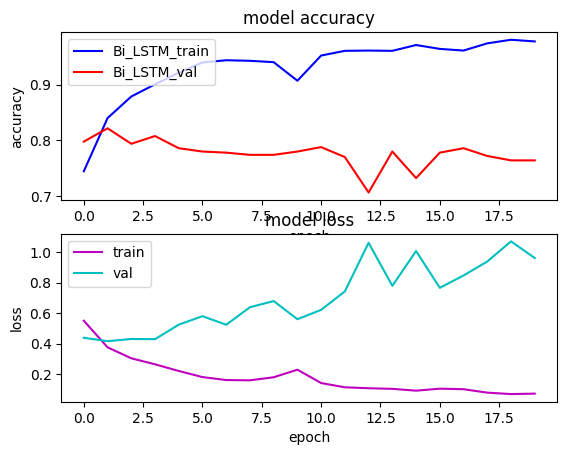

In [21]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Bi_LSTM_train', 'Bi_LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [40]:
text = ['sản phẩm tốt', 'ổn', 'k ổn', 'tệ', 'giao sai hàng', 'tạm được', 'tim']
text_tokenizer = tokenizer.texts_to_sequences(text)
padded_test = pad_sequences(text_tokenizer, maxlen=max_length, truncating='post', padding='post')
y_predict = model.predict(padded_test)

def sentiment(x:int):
    if x > 0.7:
        return 'positive'
    if x > 0.4:
        return 'neutral'
    return 'negative'

for t, pred in zip(text, y_predict):
    #print(text,':', sentiment(pred), pred)
    print(f'{t} : {sentiment(pred)} ({pred.round(decimals=3)})')

1/1 [==============================] - 0s 35ms/step
sản phẩm tốt : positive ([0.886])
ổn : neutral ([0.631])
k ổn : negative ([0.365])
tệ : negative ([0.163])
giao sai hàng : negative ([0.16])
tạm được : neutral ([0.508])
tim : positive ([0.918])
